In [1]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform


In [4]:
train_path="/content/drive/MyDrive/tn"
test_path="/content/drive/MyDrive/tt"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)
print(class_names)
print(class_names_test)
dir = os.listdir('/content/drive/MyDrive/tt')
print(dir)
file_path = ('/content/drive/MyDrive/tt')
print(file_path)
#os.rmdir('/content/drive/MyDrive/tt/.ipynb_checkpoints')
print(dir)
dir = os.listdir('/content/drive/MyDrive/tn')
print(dir)
file_path = ('/content/drive/MyDrive/tn')
print(file_path)
#os.rmdir('/content/drive/MyDrive/tn/.ipynb_checkpoints')
print(dir)

from  matplotlib import pyplot as plt
import matplotlib.image as mpimg
import random


['real', 'fake']
['real', 'fake']
['real', 'fake']
/content/drive/MyDrive/tt
['real', 'fake']
['real', 'fake']
/content/drive/MyDrive/tn
['real', 'fake']


In [ ]:
row=224
col=224
train_datagen = ImageDataGenerator(rescale=1./255,zoom_range=0.1,width_shift_range=0.1,height_shift_range=0.1,shear_range=0.1,rotation_range=5,brightness_range=(0,0.5),horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/tn",target_size=(row,col),batch_size=32,class_mode='categorical')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/tt",target_size=(row,col),batch_size=32,class_mode='categorical')


In [6]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X


In [7]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X



In [8]:
def ResNet50(input_shape=(224,224,3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model



In [9]:
def ResNet50(input_shape=(224,224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model




In [10]:
base_model = ResNet50(input_shape=(224,224, 3))
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense(2,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

model = Model(inputs=base_model.input, outputs=headModel)

import matplotlib.pyplot as plt
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(train_generator, verbose=1, validation_data = test_generator, epochs=150)

Epoch 1/150
7/7 [==============================] - 43s 4s/step - loss: 8.0669 - accuracy: 0.5701 - val_loss: 46.2920 - val_accuracy: 0.5600
Epoch 2/150
7/7 [==============================] - 7s 1s/step - loss: 0.9330 - accuracy: 0.5607 - val_loss: 1.8368 - val_accuracy: 0.5000
Epoch 3/150
7/7 [==============================] - 7s 1s/step - loss: 0.8321 - accuracy: 0.6495 - val_loss: 28.8089 - val_accuracy: 0.5000
Epoch 4/150
7/7 [==============================] - 7s 1s/step - loss: 0.6418 - accuracy: 0.6729 - val_loss: 124.0323 - val_accuracy: 0.5000
Epoch 5/150
7/7 [==============================] - 7s 1s/step - loss: 0.6039 - accuracy: 0.7009 - val_loss: 76.2581 - val_accuracy: 0.5000
Epoch 6/150
7/7 [==============================] - 7s 1s/step - loss: 0.5873 - accuracy: 0.6822 - val_loss: 21.9077 - val_accuracy: 0.5000
Epoch 7/150
7/7 [==============================] - 7s 1s/step - loss: 1.4567 - accuracy: 0.6636 - val_loss: 18.3839 - val_accuracy: 0.5000
Epoch 8/150
7/7 [=========

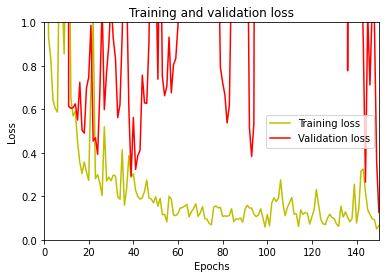

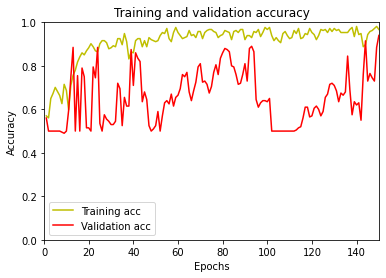

In [11]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlim(0, 150)
plt.ylim(0,1)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.xlim(0, 150)
plt.ylim(0,1)
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
import numpy as np
from PIL import Image
import sklearn.metrics as metrics
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = model.predict(test_generator,test_steps_per_epoch)
# Get most likely class
predictions = np.argmax(predictions, axis=-1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())
report = metrics.classification_report(true_classes, predictions, target_names=class_labels)
print(report)
confusion_matrix = metrics.confusion_matrix(true_classes, predictions)  # shape=(12, 12)
print(confusion_matrix)


              precision    recall  f1-score   support

        fake       0.53      0.59      0.56       100
        real       0.53      0.47      0.50       100

    accuracy                           0.53       200
   macro avg       0.53      0.53      0.53       200
weighted avg       0.53      0.53      0.53       200

[[59 41]
 [53 47]]
